In [1]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [237]:
import yfinance as yf
import glob
import umap.plot
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.preprocessing import minmax_scale

import graphistry
#from graphistry.feature_utils import FeatureMixin, get_dtypes_for_dataframe
import warnings
warnings.filterwarnings('ignore')

In [289]:
from importlib import reload
from graphistry import feature_utils
reload(feature_utils)
reload(graphistry)
from graphistry.feature_utils import get_dtypes_for_dataframe, process_dirty_dataframes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [252]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="silkspace", password="yqQg02&N") 

In [253]:
g = graphistry.bind()

In [5]:
res = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')
ndf = res[2]

In [6]:
# load bulk
tickers = ndf.Symbol
ndf

,Symbol,Name,Sector
0,AAPL,Apple,Information Technology
1,ABBV,AbbVie,Health Care
2,ABT,Abbott,Health Care
3,ACN,Accenture,Information Technology
4,ADBE,Adobe,Information Technology
...,...,...,...
96,VZ,Verizon,Communication Services
97,WBA,Walgreens Boots Alliance,Consumer Staples
98,WFC,Wells Fargo,Financials
99,WMT,Walmart,Consumer Staples


In [7]:
tickers

0      AAPL
1      ABBV
2       ABT
3       ACN
4      ADBE
       ... 
96       VZ
97      WBA
98      WFC
99      WMT
100     XOM
Name: Symbol, Length: 101, dtype: object

In [8]:
# get Electric Car Stocks 
ev_tickers = ['GM', 'F', 'XPEV', 'LI', 'NIO', 'TSLA', 'NKLA', 'RIVN', 'RIDE', 'TM',
              'GOEV', 'FSR', 'APTV', 'FUV', 'BLNK', 'LCID', 'CHPT', 'GELYF', 'MGA', 'DDAIF',
             
             'PCRFY', 'VWAGY', 'BMWYY', 'ZEV', 'SLDP', 'RMO', 'PCAR', 'LAC', #battery systems
             'NNDM', 'BWA', 'MP', 'FCX', 'ALSN', 'ALB',     #Materials Stocks
             'BEEM', 'BLNK', 'VLTA' # Charging stations + equipment
             ] 

In [9]:
df_prices_all = yf.download(tickers.to_list()+ev_tickers, start='2021-01-01', interval='1h')

[*********************100%***********************]  134 of 134 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted


In [303]:
df_prices_all.columns

MultiIndex([('Adj Close',  'AAPL'),
            ('Adj Close',  'ABBV'),
            ('Adj Close',   'ABT'),
            ('Adj Close',   'ACN'),
            ('Adj Close',  'ADBE'),
            ('Adj Close',   'AIG'),
            ('Adj Close',   'ALB'),
            ('Adj Close',  'ALSN'),
            ('Adj Close',  'AMGN'),
            ('Adj Close',   'AMT'),
            ...
            (   'Volume',     'V'),
            (   'Volume',  'VLTA'),
            (   'Volume', 'VWAGY'),
            (   'Volume',    'VZ'),
            (   'Volume',   'WBA'),
            (   'Volume',   'WFC'),
            (   'Volume',   'WMT'),
            (   'Volume',   'XOM'),
            (   'Volume',  'XPEV'),
            (   'Volume',   'ZEV')],
           length=804)

In [11]:
df_ev_all = yf.download(ev_tickers, start='2021-01-01', interval='1h')

[*********************100%***********************]  36 of 36 completed


In [29]:
df_prices_all.shape, df_ev_all.shape

((1965, 804), (1965, 216))

In [16]:
def enrich(ndf):
    """
        Get's data
    """
    tickers = ndf.Symbol
    data = []
    for tick in tickers.to_list():
        print(f'Downloading info for {tick}')
        res = yf.Ticker(tick)
        datum = res.info
        data.append(datum)
    return data

def enrich_from_tickers(tickers):
    """
        Get's data
    """
    data = []
    for tick in tickers:
        print(f'Downloading info for {tick}')
        res = yf.Ticker(tick)
        datum = res.info
        data.append(datum)
    return data


In [11]:
fetch = False
if fetch:
    data = enrich(ndf)
    df  = pd.DataFrame(data)
    df.to_csv('data/stocks_metadata.csv')
else:
    df = pd.read_csv('data/stocks_metadata.csv', index_col=0)

In [12]:
fetch = False
if fetch:
    data = enrich_from_tickers(ev_tickers)
    df2  = pd.DataFrame(data)
    df2.to_csv('data/stocks_ev_metadata.csv')
else:
    df2 = pd.read_csv('data/stocks_ev_metadata.csv', index_col=0)

In [13]:
df2.sector.unique(), df2.shape

(array(['Consumer Cyclical', 'Industrials', 'Technology',
        'Basic Materials'], dtype=object),
 (37, 155))

In [14]:
df.sector.unique(), df.shape

(array(['Technology', 'Healthcare', 'Financial Services', 'Real Estate',
        'Consumer Cyclical', 'Industrials', nan, 'Communication Services',
        'Consumer Defensive', 'Energy', 'Basic Materials', 'Utilities'],
       dtype=object),
 (101, 159))

In [15]:
df_meta_all = pd.concat([df, df2], axis=0, ignore_index=True)

In [17]:
df_meta_all=df_meta_all[~df_meta_all.symbol.isin(['BRK.B'])]

In [18]:
np.where(df_meta_all.symbol=='BRK.B')

(array([], dtype=int64),)

In [19]:
df_meta_all.to_csv('data/stocks_all.csv')

In [20]:
df_meta_all.symbol.isin(['BRK.B']).sum() # whoot

0

In [328]:
o = df_prices_all.Open
h = df_prices_all.High
l = df_prices_all.Low
c = df_prices_all.Close

# square of GARMAN-KLASS rv estimator from OLHC data
vol = 1/2 * np.square(np.log(h/l)) - (2*np.log(2)-1)*np.square(np.log(c/o))

# square of Rogers-Satchell Volatility 
vol2 = np.log(h/c)*np.log(h/o)+ np.log(l/c)*np.log(l/o)

In [309]:
vol.columns[vol.columns!='BRK.B']

Index(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'ALB', 'ALSN', 'AMGN',
       'AMT',
       ...
       'V', 'VLTA', 'VWAGY', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM', 'XPEV', 'ZEV'],
      dtype='object', length=133)

In [310]:
vol

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALB,ALSN,AMGN,AMT,...,V,VLTA,VWAGY,VZ,WBA,WFC,WMT,XOM,XPEV,ZEV
2021-01-04 09:30:00-05:00,0.000160,0.000048,0.000029,0.000022,0.000097,0.000133,0.000447,0.000153,0.000047,0.000048,...,0.000090,NaN,0.000170,0.000051,0.000151,0.000171,0.000066,0.000163,0.000534,NaN
2021-01-04 10:30:00-05:00,0.000077,0.000021,0.000045,0.000085,0.000083,0.000074,0.000452,0.000190,0.000052,0.000040,...,0.000055,NaN,0.000054,0.000011,0.000064,0.000067,0.000010,0.000094,0.000975,NaN
2021-01-04 11:30:00-05:00,0.000274,0.000031,0.000047,0.000056,0.000114,0.000026,0.000185,0.000087,0.000038,0.000019,...,0.000019,NaN,0.000060,0.000005,0.000053,0.000026,0.000018,0.000036,0.001095,NaN
2021-01-04 12:30:00-05:00,0.000052,0.000040,0.000028,0.000030,0.000063,0.000054,0.000098,0.000056,0.000013,0.000010,...,0.000021,NaN,0.000010,0.000007,0.000090,0.000046,0.000030,0.000072,0.000113,NaN
2021-01-04 13:30:00-05:00,0.000011,0.000005,0.000004,0.000005,0.000020,0.000039,0.000048,0.000023,0.000012,0.000015,...,0.000012,NaN,0.000015,0.000002,0.000017,0.000017,0.000004,0.000023,0.000091,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:30:00-05:00,0.000013,0.000006,0.000009,0.000014,0.000041,0.000017,0.000035,0.000011,0.000007,0.000025,...,0.000035,0.000173,0.000005,0.000004,0.000009,0.000035,0.000006,0.000010,0.000055,0.000216
2022-02-11 12:30:00-05:00,0.000011,0.000006,0.000006,0.000014,0.000022,0.000012,0.000035,0.000008,0.000003,0.000021,...,0.000008,0.000124,0.000002,0.000006,0.000013,0.000018,0.000007,0.000010,0.000034,0.000209
2022-02-11 13:30:00-05:00,0.000057,0.000039,0.000033,0.000033,0.000034,0.000048,0.000181,0.000046,0.000033,0.000048,...,0.000074,0.000106,0.000030,0.000038,0.000041,0.000035,0.000060,0.000090,0.000107,0.000369
2022-02-11 14:30:00-05:00,0.000042,0.000018,0.000030,0.000043,0.000083,0.000131,0.000077,0.000056,0.000017,0.000033,...,0.000040,0.000313,0.000047,0.000012,0.000080,0.000070,0.000014,0.000024,0.000134,0.000283


In [329]:
vol = vol.replace([np.inf, np.nan], 0)

In [324]:
#vol.T['n'] = range(len(vol.T))

In [327]:
vol.T

,2021-01-04 09:30:00-05:00,2021-01-04 10:30:00-05:00,2021-01-04 11:30:00-05:00,2021-01-04 12:30:00-05:00,2021-01-04 13:30:00-05:00,2021-01-04 14:30:00-05:00,2021-01-04 15:30:00-05:00,2021-01-05 09:30:00-05:00,2021-01-05 10:30:00-05:00,2021-01-05 11:30:00-05:00,...,2022-02-10 13:30:00-05:00,2022-02-10 14:30:00-05:00,2022-02-10 15:30:00-05:00,2022-02-11 09:30:00-05:00,2022-02-11 10:30:00-05:00,2022-02-11 11:30:00-05:00,2022-02-11 12:30:00-05:00,2022-02-11 13:30:00-05:00,2022-02-11 14:30:00-05:00,2022-02-11 15:30:00-05:00
AAPL,0.000160,0.000077,0.000274,0.000052,0.000011,0.000026,0.000026,0.000217,0.000054,0.000020,...,0.000019,0.000019,0.000028,0.000061,0.000027,0.000013,0.000011,0.000057,0.000042,0.000046
ABBV,0.000048,0.000021,0.000031,0.000040,0.000005,0.000016,0.000005,0.000055,0.000019,0.000026,...,0.000003,0.000003,0.000011,0.000026,0.000004,0.000006,0.000006,0.000039,0.000018,0.000014
ABT,0.000029,0.000045,0.000047,0.000028,0.000004,0.000019,0.000022,0.000044,0.000026,0.000012,...,0.000018,0.000008,0.000015,0.000067,0.000031,0.000009,0.000006,0.000033,0.000030,0.000022
ACN,0.000022,0.000085,0.000056,0.000030,0.000005,0.000009,0.000018,0.000035,0.000012,0.000010,...,0.000030,0.000037,0.000035,0.000089,0.000064,0.000014,0.000014,0.000033,0.000043,0.000051
ADBE,0.000097,0.000083,0.000114,0.000063,0.000020,0.000014,0.000024,0.000034,0.000019,0.000027,...,0.000060,0.000030,0.000033,0.000092,0.000055,0.000041,0.000022,0.000034,0.000083,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFC,0.000171,0.000067,0.000026,0.000046,0.000017,0.000035,0.000020,0.000133,0.000108,0.000029,...,0.000034,0.000018,0.000022,0.000176,0.000033,0.000035,0.000018,0.000035,0.000070,0.000056
WMT,0.000066,0.000010,0.000018,0.000030,0.000004,0.000009,0.000020,0.000102,0.000010,0.000005,...,0.000011,0.000008,0.000011,0.000019,0.000006,0.000006,0.000007,0.000060,0.000014,0.000016
XOM,0.000163,0.000094,0.000036,0.000072,0.000023,0.000007,0.000033,0.000129,0.000097,0.000042,...,0.000009,0.000009,0.000023,0.000091,0.000016,0.000010,0.000010,0.000090,0.000024,0.000019
XPEV,0.000534,0.000975,0.001095,0.000113,0.000091,0.000137,0.000087,0.001732,0.000193,0.000240,...,0.000076,0.000129,0.000086,0.000924,0.000233,0.000055,0.000034,0.000107,0.000134,0.000094


In [330]:
g2 = g.nodes(vol.T).featurize()

[feature_utils.py:320 -  get_textual_columns() ] No Textual Columns were found
[feature_utils.py:425 - process_dirty_dataframes() ] Encoding might take a few minutes --------
[feature_utils.py:442 - process_dirty_dataframes() ] -*-*-DataFrame is already completely numeric
[feature_utils.py:446 - process_dirty_dataframes() ] -Shape of data (134, 1965)

[feature_utils.py:447 - process_dirty_dataframes() ] -Columns: DatetimeIndex(['2021-01-04 09:30:00-05:00', '2021-01-04 10:30:00-05:00',
               '2021-01-04 11:30:00-05:00', '2021-01-04 12:30:00-05:00',
               '2021-01-04 13:30:00-05:00', '2021-01-04 14:30:00-05:00',
               '2021-01-04 15:30:00-05:00', '2021-01-05 09:30:00-05:00',
               '2021-01-05 10:30:00-05:00', '2021-01-05 11:30:00-05:00',
               '2021-01-05 12:30:00-05:00', '2021-01-05 13:30:00-05:00',
               '2021-01-05 14:30:00-05:00', '2021-01-05 15:30:00-05:00',
               '2021-01-06 09:30:00-05:00', '2021-01-06 10:30:00-05:00',

In [331]:
g3 = g2.umap(scale = 2)

[feature_utils.py:662 - _featurize_or_get_nodes_data_if_X_is_None() ] Found Node features in `res`
[feature_utils.py:674 - _featurize_or_get_nodes_data_if_X_is_None() ] Fetching `node_target` in `res`. Target is type <class 'NoneType'>
[umap_utils.py:93 -                  fit() ] Starting UMAP-ing data of shape (134, 1965)
[umap_utils.py:106 -      _edge_influence() ] Calculating weighted adjacency (edge) DataFrame
[umap_utils.py:97 -                  fit() ] -UMAP-ing took 0.04 minutes total
[umap_utils.py:98 -                  fit() ]  - or 3585.91 rows per minute
[feature_utils.py:555 - prune_weighted_edges_df() ] Pruning weighted edge DataFrame from 2732 to 284 edges


In [332]:
g3.weighted_edges_df_from_nodes

,_src,_dst,weight
11,0,119,1.0
14,1,56,1.0
35,2,121,1.0
44,3,34,1.0
65,3,124,1.0
...,...,...,...
2682,131,33,1.0
2683,131,38,1.0
2713,132,91,1.0
2715,132,94,1.0


In [333]:
g2 = g.nodes(meta, 'n').edges(g3._edges, '_src', '_dst')
g2.plot()

<AxesSubplot:>

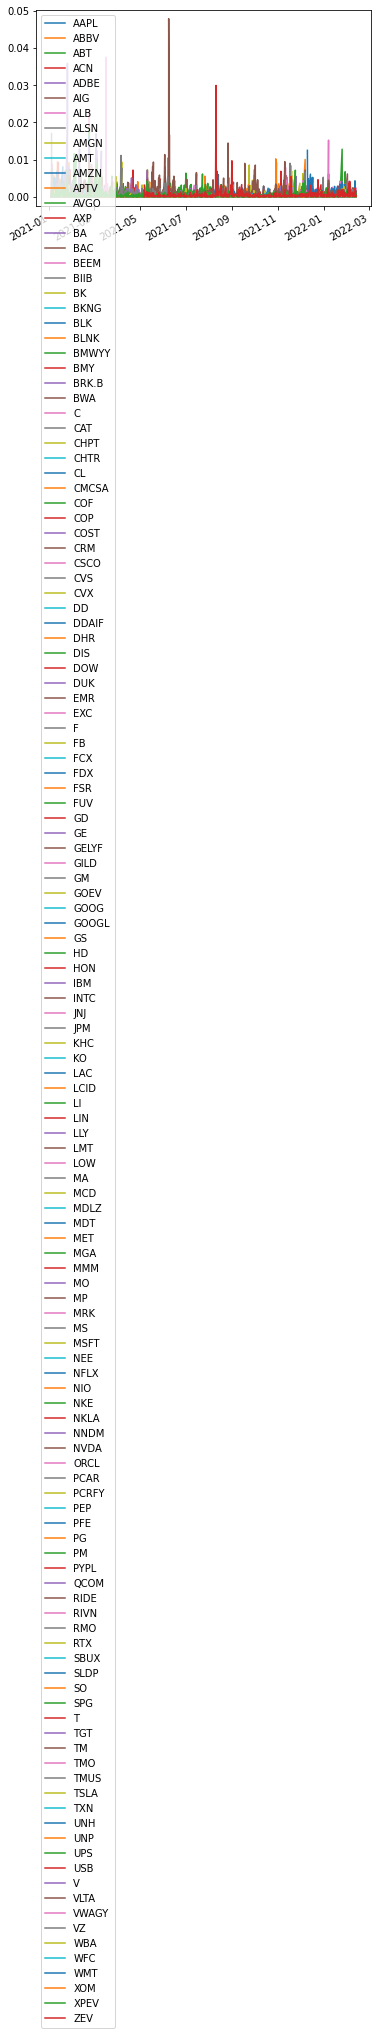

In [33]:
vol.plot()

<AxesSubplot:>

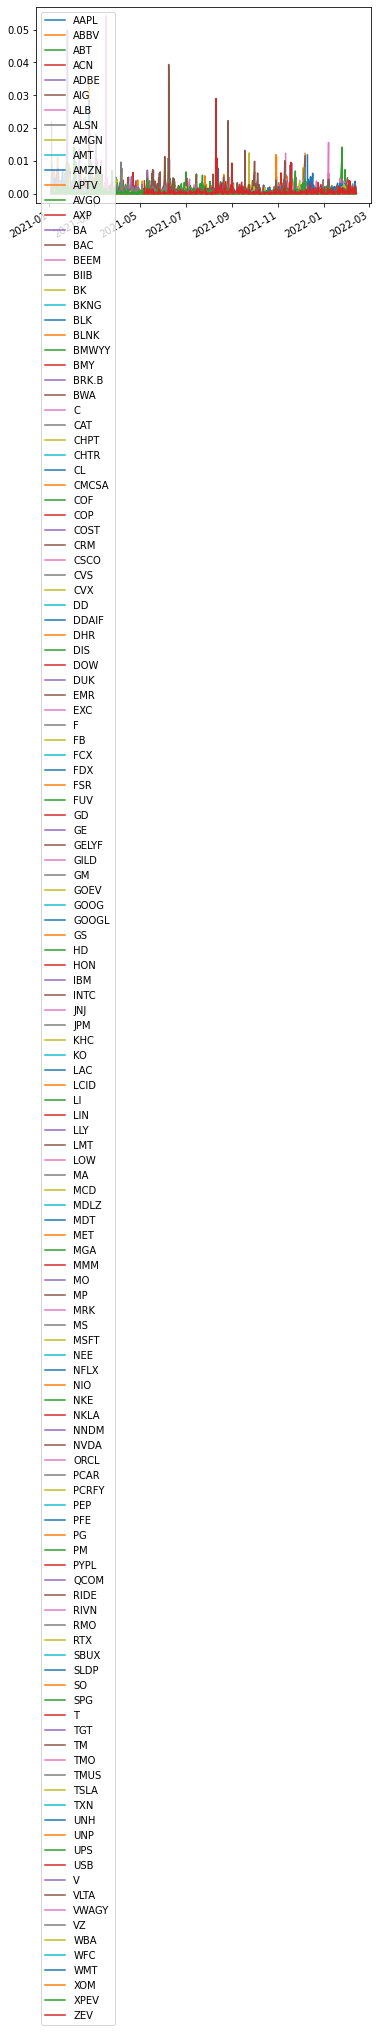

In [34]:
vol2.plot()

In [ ]:
((vol-vol2)**2).plot()

In [22]:
df_prices = df_prices_all['Adj Close']

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

colnames = df_prices.columns
dates = df_prices.index

# impute values 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(df_prices)
res = imputer.transform(df_prices)
df_prices = pd.DataFrame(res, index=df_prices.index, columns = df_prices.columns)

# scale the resulting values
scaler = MinMaxScaler()

df_prices = pd.DataFrame(scaler.fit_transform(df_prices), index=dates, columns=colnames)
df_prices
# df_prices = df_prices.fillna(df_prices.mean())
# df_prices = df_prices.dropna(axis=1, how='any')

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALB,ALSN,AMGN,AMT,...,V,VLTA,VWAGY,VZ,WBA,WFC,WMT,XOM,XPEV,ZEV
2021-01-04 09:30:00-05:00,0.222530,0.085523,0.117631,0.099937,0.270604,0.012525,0.142782,0.754539,0.474203,0.229443,...,0.441150,0.458986,0.014772,0.893214,0.000000,0.012012,0.762543,0.008811,0.660325,0.459517
2021-01-04 10:30:00-05:00,0.204936,0.073818,0.079721,0.087706,0.241924,0.005506,0.119399,0.727669,0.449392,0.213557,...,0.415248,0.458986,0.016115,0.883214,0.019741,0.004908,0.769724,0.001677,0.659561,0.459517
2021-01-04 11:30:00-05:00,0.179954,0.057095,0.051289,0.077022,0.216761,0.000000,0.109928,0.699709,0.415955,0.210195,...,0.408895,0.458986,0.009288,0.890030,0.036177,0.000000,0.728819,0.000719,0.620034,0.459517
2021-01-04 12:30:00-05:00,0.191948,0.061276,0.063275,0.080946,0.218077,0.010059,0.120658,0.699346,0.417351,0.209719,...,0.423344,0.458986,0.013429,0.878244,0.049141,0.004548,0.743492,0.007069,0.603805,0.459517
2021-01-04 13:30:00-05:00,0.190737,0.065456,0.071080,0.075504,0.224138,0.008731,0.116917,0.684822,0.436247,0.211815,...,0.435448,0.458986,0.014772,0.895210,0.053964,0.001800,0.740089,0.003118,0.587577,0.459517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11 11:30:00-05:00,0.841458,0.966794,0.581185,0.532253,0.240913,0.968507,0.666296,0.514815,0.517992,0.390373,...,0.604794,0.138373,0.404476,0.334831,0.570093,0.994110,0.342011,0.905102,0.419717,0.170331
2022-02-11 12:30:00-05:00,0.829537,0.968467,0.574774,0.523258,0.228612,0.948207,0.653103,0.503268,0.518978,0.371406,...,0.603079,0.134104,0.401522,0.336826,0.565571,0.971041,0.340809,0.900549,0.413542,0.172972
2022-02-11 13:30:00-05:00,0.798481,0.967463,0.551638,0.500831,0.205884,0.902296,0.623579,0.473493,0.507558,0.363602,...,0.558605,0.116498,0.379588,0.342315,0.540850,0.945026,0.322587,0.914424,0.385003,0.138113
2022-02-11 14:30:00-05:00,0.796280,0.960822,0.555540,0.497565,0.202836,0.888257,0.629393,0.480029,0.505258,0.361315,...,0.565886,0.118099,0.369740,0.354292,0.501357,0.938973,0.333605,0.930503,0.392557,0.138641


In [31]:
df_meta_all = df_meta_all.drop_duplicates(subset=['symbol'])

In [35]:
df_meta_all.columns

Index(['zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city',
       'phone', 'state', 'country', 'companyOfficers', 'website',
       ...
       'regularMarketPrice', 'preMarketPrice', 'logo_url', 'trailingPegRatio',
       'address2', 'fax', 'underlyingSymbol', 'underlyingExchangeSymbol',
       'headSymbol', 'uuid'],
      dtype='object', length=159)

In [42]:
def choose_good_cols(df): # silly
    from time import time
    t = time()
    good_cols=[]
    for col in df.columns:
        print('-'*20)
        print(col)
        print(df[col].sample(2).values)
        res = input('\nGood?')
        if res !='':
            print(f'Yeah for {col}!!!')
            good_cols.append(col)
    print(f'took {(time()-t)/60:.2f} minutes')
    return good_cols

tdf = df_meta_all

good_cols = choose_good_cols(tdf)

--------------------
zip
['GU2 7XY' '91521']

Good?
--------------------
sector
['Consumer Cyclical' 'Consumer Defensive']

Good?a
Yeah for sector!!!
--------------------
fullTimeEmployees
[ 70757. 114000.]

Good?a
Yeah for fullTimeEmployees!!!
--------------------
longBusinessSummary
['Solid Power Inc. develops all-solid-state battery cells for electric vehicles and mobile power markets in the United States. The company was incorporated in 2011 and is based in Louisville, Colorado.'
 'Walgreens Boots Alliance, Inc. operates as a pharmacy-led health and beauty retail company. It operates through two segments, the United States and International. The United States segment sells prescription drugs and an assortment of retail products, including health, wellness, beauty, personal care, consumable, and general merchandise products through its retail drugstores. It also provides central specialty pharmacy services and mail services. As of August 31, 2021, this segment operated 8,965 retail 


Good?a
Yeah for yield!!!
--------------------
mostRecentQuarter
[1.6329600e+09 1.6356384e+09]

Good?a
Yeah for mostRecentQuarter!!!
--------------------
shortRatio
[1.74 1.18]

Good?a
Yeah for shortRatio!!!
--------------------
sharesShortPreviousMonthDate
[1.6369344e+09 1.6369344e+09]

Good?a
Yeah for sharesShortPreviousMonthDate!!!
--------------------
floatShares
[4.81588758e+08 8.07597300e+06]

Good?a
Yeah for floatShares!!!
--------------------
beta
[0.872727 0.891948]

Good?a
Yeah for beta!!!
--------------------
enterpriseValue
[7.12796324e+10 7.48416287e+10]

Good?a
Yeah for enterpriseValue!!!
--------------------
priceHint
[2 2]

Good?a
Yeah for priceHint!!!
--------------------
threeYearAverageReturn
[nan nan]

Good?a
Yeah for threeYearAverageReturn!!!
--------------------
lastSplitDate
[9.383904e+08 9.607680e+08]

Good?a
Yeah for lastSplitDate!!!
--------------------
lastSplitFactor
['1319:1000' '3:2']

Good?a
Yeah for lastSplitFactor!!!
--------------------
legalType
[nan 

['sector',
 'fullTimeEmployees',
 'longBusinessSummary',
 'industry',
 'ebitdaMargins',
 'profitMargins',
 'grossMargins',
 'operatingCashflow',
 'revenueGrowth',
 'operatingMargins',
 'ebitda',
 'targetLowPrice',
 'recommendationKey',
 'grossProfits',
 'freeCashflow',
 'targetMedianPrice',
 'currentPrice',
 'earningsGrowth',
 'currentRatio',
 'returnOnAssets',
 'numberOfAnalystOpinions',
 'targetMeanPrice',
 'debtToEquity',
 'returnOnEquity',
 'targetHighPrice',
 'totalCash',
 'totalDebt',
 'totalRevenue',
 'totalCashPerShare',
 'financialCurrency',
 'revenuePerShare',
 'quickRatio',
 'recommendationMean',
 'isEsgPopulated',
 'quoteType',
 'market',
 'enterpriseToRevenue',
 'enterpriseToEbitda',
 '52WeekChange',
 'morningStarRiskRating',
 'forwardEps',
 'revenueQuarterlyGrowth',
 'sharesOutstanding',
 'fundInceptionDate',
 'annualReportExpenseRatio',
 'totalAssets',
 'bookValue',
 'sharesShort',
 'sharesPercentSharesOut',
 'fundFamily',
 'lastFiscalYearEnd',
 'heldPercentInstitutions'

In [44]:
df_meta_all[good_cols]

,sector,fullTimeEmployees,longBusinessSummary,industry,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,...,fiftyTwoWeekHigh,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,dividendYield,bidSize,dayHigh,regularMarketPrice,preMarketPrice,trailingPegRatio
0,Technology,100000.0,"Apple Inc. designs, manufactures, and markets ...",Consumer Electronics,0.33891,0.26579,0.43019,1.122410e+11,0.112,0.30900,...,182.94,1.15,116.210,173.13,0.0050,800.0,175.4800,173.015,174.00,3.3581
1,Healthcare,NaN,"AbbVie Inc. discovers, develops, manufactures,...",Drug Manufacturers—General,0.50287,0.20538,0.69338,NaN,0.074,0.34765,...,144.42,4.28,102.050,142.63,0.0394,1100.0,144.4200,142.600,143.33,NaN
2,Healthcare,113000.0,"Abbott Laboratories discovers, develops, manuf...",Medical Devices,0.29755,0.16416,0.57962,NaN,0.072,0.21537,...,142.60,1.61,105.360,128.10,0.0144,800.0,129.9200,127.990,128.94,2.4397
3,Technology,624000.0,"Accenture plc, a professional services company...",Information Technology Services,0.16804,0.11533,0.32348,7.903174e+09,0.272,0.15195,...,417.37,1.50,244.440,342.00,0.0109,1100.0,351.5050,342.280,346.97,2.7366
4,Technology,25988.0,Adobe Inc. operates as a diversified software ...,Software—Infrastructure,0.40405,0.30548,0.88185,7.230000e+09,0.200,0.36756,...,699.54,NaN,420.780,498.29,NaN,800.0,514.4799,498.190,509.14,1.9890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Basic Materials,NaN,Freeport-McMoRan Inc. engages in the mining of...,Copper,0.45419,0.18849,0.47735,7.715000e+09,0.371,0.36673,...,46.20,NaN,29.450,42.83,0.0068,900.0,44.1750,42.800,42.79,NaN
133,Consumer Cyclical,3300.0,"Allison Transmission Holdings, Inc., together ...",Auto Parts,0.34453,0.16747,0.47667,6.260000e+08,0.066,0.27955,...,46.40,1.58,32.550,39.10,0.0194,800.0,39.8950,39.260,39.00,16.6584
134,Basic Materials,5900.0,"Albemarle Corporation develops, manufactures, ...",Specialty Chemicals,0.24434,0.06403,0.31033,8.277860e+08,0.112,0.16962,...,291.48,1.40,133.820,230.90,0.0066,1000.0,239.0350,230.890,234.44,2.0313
135,Technology,29.0,"Beam Global, a cleantech company, designs, dev...",Solar,-0.89100,-0.89668,-0.15152,-6.067417e+06,0.633,-0.89713,...,65.12,NaN,10.188,12.80,NaN,900.0,14.5799,13.210,14.16,NaN


In [80]:
df_meta_all.sector.unique()

array(['Technology', 'Healthcare', 'Financial Services', 'Real Estate',
       'Consumer Cyclical', 'Industrials', 'Communication Services',
       'Consumer Defensive', 'Energy', 'Basic Materials', 'Utilities',
       nan], dtype=object)

In [46]:
df_meta_all = df_meta_all.drop(columns=['companyOfficers'])

In [52]:
gtypes = get_dtypes_for_dataframe(df_meta_all, verbose=True)

[feature_utils.py:206 - get_dtypes_for_dataframe() ] bool has 2 members
[feature_utils.py:206 - get_dtypes_for_dataframe() ] int64 has 2 members
[feature_utils.py:206 - get_dtypes_for_dataframe() ] float64 has 127 members
[feature_utils.py:206 - get_dtypes_for_dataframe() ] object has 27 members


In [212]:
numeric_df = df_meta_all[gtypes['float64'] + gtypes['int64']]
numeric_df = numeric_df.replace([np.inf, np.nan], 0)

In [213]:
meta.describe()

,longBusinessSummary,industry,sector,financialCurrency,symbol,longName
count,133,133,133,133,133,133
unique,131,57,12,5,133,132
top,,Auto Manufacturers,Consumer Cyclical,USD,AAPL,Alphabet Inc.
freq,2,17,31,122,1,2


In [214]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
res = imputer.fit_transform(numeric_df)
numeric_df = pd.DataFrame(res, index=numeric_df.index, columns = numeric_df.columns)

In [215]:
numeric_df['symbol'] = df_meta_all.symbol

In [216]:
numeric_df = numeric_df.drop_duplicates(subset='symbol', ignore_index=True)

In [217]:
numeric_df

,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,grossProfits,...,dayHigh,regularMarketPrice,preMarketPrice,trailingPegRatio,underlyingSymbol,underlyingExchangeSymbol,headSymbol,maxAge,priceHint,symbol
0,100000.0,0.33891,0.26579,0.43019,1.122410e+11,0.112,0.30900,1.282180e+11,160.0,1.528360e+11,...,175.4800,173.015,174.00,3.3581,0.0,0.0,0.0,1.0,2.0,AAPL
1,0.0,0.50287,0.20538,0.69338,0.000000e+00,0.074,0.34765,2.825966e+10,115.0,3.896600e+10,...,144.4200,142.600,143.33,0.0000,0.0,0.0,0.0,1.0,2.0,ABBV
2,113000.0,0.29755,0.16416,0.57962,0.000000e+00,0.072,0.21537,1.281700e+10,115.0,2.496700e+10,...,129.9200,127.990,128.94,2.4397,0.0,0.0,0.0,1.0,2.0,ABT
3,624000.0,0.16804,0.11533,0.32348,7.903174e+09,0.272,0.15195,9.030121e+09,0.0,1.636413e+10,...,351.5050,342.280,346.97,2.7366,0.0,0.0,0.0,1.0,2.0,ACN
4,25988.0,0.40405,0.30548,0.88185,7.230000e+09,0.200,0.36756,6.378000e+09,560.0,1.392000e+10,...,514.4799,498.190,509.14,1.9890,0.0,0.0,0.0,1.0,2.0,ADBE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.0,0.45419,0.18849,0.47735,7.715000e+09,0.371,0.36673,1.037600e+10,28.0,1.090500e+10,...,44.1750,42.800,42.79,0.0000,0.0,0.0,0.0,1.0,2.0,FCX
129,3300.0,0.34453,0.16747,0.47667,6.260000e+08,0.066,0.27955,7.900000e+08,30.0,1.003000e+09,...,39.8950,39.260,39.00,16.6584,0.0,0.0,0.0,1.0,2.0,ALSN
130,5900.0,0.24434,0.06403,0.31033,8.277860e+08,0.112,0.16962,8.094710e+08,80.0,9.968530e+08,...,239.0350,230.890,234.44,2.0313,0.0,0.0,0.0,1.0,2.0,ALB
131,29.0,-0.89100,-0.89668,-0.15152,-6.067417e+06,0.633,-0.89713,-6.873875e+06,12.0,-7.109740e+05,...,14.5799,13.210,14.16,0.0000,0.0,0.0,0.0,1.0,2.0,BEEM


In [243]:
if False is not None:
    print('YES')

YES


In [254]:
g2 = g.nodes(numeric_df, 'symbol').featurize()

[feature_utils.py:143 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `symbol` so we do not featurize it
[feature_utils.py:320 -  get_textual_columns() ] No Textual Columns were found
[feature_utils.py:425 - process_dirty_dataframes() ] Encoding might take a few minutes --------
[feature_utils.py:442 - process_dirty_dataframes() ] -DataFrame is already completely numeric
[feature_utils.py:446 - process_dirty_dataframes() ] -Shape of data (133, 129)

[feature_utils.py:447 - process_dirty_dataframes() ] -Columns: Index(['fullTimeEmployees', 'ebitdaMargins', 'profitMargins', 'grossMargins',
       'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda',
       'targetLowPrice', 'grossProfits', 'freeCashflow', 'targetMedianPrice',
       'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets',
       'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity',
       'returnOnEquity'],
      dtype='object')...

[feature_utils.py:378 - p

In [255]:
g2.node_features

,fullTimeEmployees,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,targetLowPrice,grossProfits,...,bidSize,dayHigh,regularMarketPrice,preMarketPrice,trailingPegRatio,underlyingSymbol,underlyingExchangeSymbol,headSymbol,maxAge,priceHint
0,100000.0,0.33891,0.26579,0.43019,1.122410e+11,0.112,0.30900,1.282180e+11,160.0,1.528360e+11,...,800.0,175.4800,173.015,174.00,3.3581,0.0,0.0,0.0,1.0,2.0
1,0.0,0.50287,0.20538,0.69338,0.000000e+00,0.074,0.34765,2.825966e+10,115.0,3.896600e+10,...,1100.0,144.4200,142.600,143.33,0.0000,0.0,0.0,0.0,1.0,2.0
2,113000.0,0.29755,0.16416,0.57962,0.000000e+00,0.072,0.21537,1.281700e+10,115.0,2.496700e+10,...,800.0,129.9200,127.990,128.94,2.4397,0.0,0.0,0.0,1.0,2.0
3,624000.0,0.16804,0.11533,0.32348,7.903174e+09,0.272,0.15195,9.030121e+09,0.0,1.636413e+10,...,1100.0,351.5050,342.280,346.97,2.7366,0.0,0.0,0.0,1.0,2.0
4,25988.0,0.40405,0.30548,0.88185,7.230000e+09,0.200,0.36756,6.378000e+09,560.0,1.392000e+10,...,800.0,514.4799,498.190,509.14,1.9890,0.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,0.0,0.45419,0.18849,0.47735,7.715000e+09,0.371,0.36673,1.037600e+10,28.0,1.090500e+10,...,900.0,44.1750,42.800,42.79,0.0000,0.0,0.0,0.0,1.0,2.0
129,3300.0,0.34453,0.16747,0.47667,6.260000e+08,0.066,0.27955,7.900000e+08,30.0,1.003000e+09,...,800.0,39.8950,39.260,39.00,16.6584,0.0,0.0,0.0,1.0,2.0
130,5900.0,0.24434,0.06403,0.31033,8.277860e+08,0.112,0.16962,8.094710e+08,80.0,9.968530e+08,...,1000.0,239.0350,230.890,234.44,2.0313,0.0,0.0,0.0,1.0,2.0
131,29.0,-0.89100,-0.89668,-0.15152,-6.067417e+06,0.633,-0.89713,-6.873875e+06,12.0,-7.109740e+05,...,900.0,14.5799,13.210,14.16,0.0000,0.0,0.0,0.0,1.0,2.0


In [261]:
g2 = g.nodes(numeric_df, 'symbol').featurize()
g3 = g2.umap(scale=.51, n_neighbors=10)

[feature_utils.py:143 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `symbol` so we do not featurize it
[feature_utils.py:320 -  get_textual_columns() ] No Textual Columns were found
[feature_utils.py:425 - process_dirty_dataframes() ] Encoding might take a few minutes --------
[feature_utils.py:442 - process_dirty_dataframes() ] -DataFrame is already completely numeric
[feature_utils.py:446 - process_dirty_dataframes() ] -Shape of data (133, 129)

[feature_utils.py:447 - process_dirty_dataframes() ] -Columns: Index(['fullTimeEmployees', 'ebitdaMargins', 'profitMargins', 'grossMargins',
       'operatingCashflow', 'revenueGrowth', 'operatingMargins', 'ebitda',
       'targetLowPrice', 'grossProfits', 'freeCashflow', 'targetMedianPrice',
       'currentPrice', 'earningsGrowth', 'currentRatio', 'returnOnAssets',
       'numberOfAnalystOpinions', 'targetMeanPrice', 'debtToEquity',
       'returnOnEquity'],
      dtype='object')...

[feature_utils.py:378 - p

In [263]:
g3.plot()

In [259]:
meta['n'] = range(len(meta))

In [262]:
g4 = g.nodes(meta, 'n').edges(g3.weighted_edges_df_from_nodes, '_src', '_dst')
g4.plot()

In [302]:
vol.shape

(1965, 134)

# Now we are ready to featurize succesive DataFrames

We will focus on Textual + categorical columns first, and call it 'meta'

In [173]:
df_meta_all[gtypes['object']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 137
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   zip                        130 non-null    object
 1   sector                     131 non-null    object
 2   longBusinessSummary        131 non-null    object
 3   city                       131 non-null    object
 4   phone                      131 non-null    object
 5   state                      117 non-null    object
 6   country                    131 non-null    object
 7   website                    131 non-null    object
 8   address1                   131 non-null    object
 9   industry                   131 non-null    object
 10  recommendationKey          131 non-null    object
 11  financialCurrency          131 non-null    object
 12  exchange                   133 non-null    object
 13  shortName                  133 non-null    object
 14  longName  

In [129]:
# out of these, we only want ['longBusinessSummary', 'industry', 'sector', 'financialCurrency', 'symbol']

In [174]:
meta = df_meta_all[['longBusinessSummary', 'industry', 'sector', 'financialCurrency', 'symbol', 'longName']]
meta = meta.fillna('')

In [299]:
g2 = g.nodes(meta, 'symbol').featurize()

[feature_utils.py:143 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `symbol` so we do not featurize it
[feature_utils.py:297 - check_if_textual_column() ] 
	Column `longBusinessSummary` looks textual with mean number of words 178.20
[feature_utils.py:353 - process_textual_or_other_dataframes() ] -Calculating Embeddings for column `longBusinessSummary`
[feature_utils.py:425 - process_dirty_dataframes() ] Encoding might take a few minutes --------
[feature_utils.py:431 - process_dirty_dataframes() ] -Shape of data (133, 102)

[feature_utils.py:432 - process_dirty_dataframes() ] -Transformers: [('low_card_cat', OneHotEncoder(), ['sector', 'financialCurrency']), ('high_card_cat', GapEncoder(n_components=42), ['industry', 'longName'])]

[feature_utils.py:433 - process_dirty_dataframes() ] -Transformed Columns: ['sector_', 'sector_Basic Materials', 'sector_Communication Services', 'sector_Consumer Cyclical', 'sector_Consumer Defensive', 'sector_Energy', 'sect

In [300]:
g3 = g2.umap(scale=0.5, n_neighbors=10)

[feature_utils.py:787 -                 umap() ] There are repeat entities in node table, we will not relabel nodes
[feature_utils.py:662 - _featurize_or_get_nodes_data_if_X_is_None() ] Found Node features in `res`
[feature_utils.py:674 - _featurize_or_get_nodes_data_if_X_is_None() ] Fetching `node_target` in `res`. Target is type <class 'NoneType'>
[umap_utils.py:93 -                  fit() ] Starting UMAP-ing data of shape (133, 486)
[umap_utils.py:106 -      _edge_influence() ] Calculating weighted adjacency (edge) DataFrame
[umap_utils.py:97 -                  fit() ] -UMAP-ing took 0.04 minutes total
[umap_utils.py:98 -                  fit() ]  - or 3334.70 rows per minute
[feature_utils.py:555 - prune_weighted_edges_df() ] Pruning weighted edge DataFrame from 1942 to 430 edges


## Now we may plot it to see similarity

In [301]:
g3.plot()

In [267]:
df_meta = pd.concat([meta, numeric_df], axis=1)

In [269]:
remove_cols = np.array(df_meta.columns)[np.where(df_meta.sum(0)==0)[0]]

In [270]:
remove_cols

array(['totalRevenue', 'revenuePerShare', 'gmtOffSetMilliseconds',
       'enterpriseToRevenue', 'enterpriseToEbitda', '52WeekChange',
       'morningStarRiskRating', 'fundInceptionDate', 'trailingEps',
       'mostRecentQuarter', 'sharesShortPreviousMonthDate', 'beta',
       'lastDividendDate', 'earningsQuarterlyGrowth', 'ytdReturn',
       'forwardPE', 'fiveYearAverageReturn', 'regularMarketOpen',
       'navPrice', 'regularMarketPreviousClose', 'fiftyDayAverage',
       'toCurrency', 'averageVolume10days', 'exDividendDate',
       'circulatingSupply', 'startDate', 'trailingPE',
       'regularMarketVolume', 'averageVolume', 'dividendYield', 'bidSize',
       'dayHigh'], dtype=object)

In [277]:
df_meta = df_meta.drop(columns=remove_cols)

In [281]:
for k, v in df_meta.mean().items():
    df_meta[k] = df_meta[k].fillna(v)

In [282]:
df_meta

,longBusinessSummary,industry,sector,financialCurrency,symbol,longName,n,fullTimeEmployees,ebitdaMargins,profitMargins,...,bid,regularMarketPrice,preMarketPrice,trailingPegRatio,underlyingSymbol,underlyingExchangeSymbol,headSymbol,maxAge,priceHint,symbol
0,"Apple Inc. designs, manufactures, and markets ...",Consumer Electronics,Technology,USD,AAPL,Apple Inc.,0.0,100000.000000,0.338910,0.265790,...,173.130000,173.015000,174.000000,3.35810,0.0,0.0,0.0,1.0,2.000000,AAPL
1,"AbbVie Inc. discovers, develops, manufactures,...",Drug Manufacturers—General,Healthcare,USD,ABBV,AbbVie Inc.,1.0,0.000000,0.502870,0.205380,...,142.630000,142.600000,143.330000,0.00000,0.0,0.0,0.0,1.0,2.000000,ABBV
2,"Abbott Laboratories discovers, develops, manuf...",Medical Devices,Healthcare,USD,ABT,Abbott Laboratories,2.0,113000.000000,0.297550,0.164160,...,128.100000,127.990000,128.940000,2.43970,0.0,0.0,0.0,1.0,2.000000,ABT
3,"Accenture plc, a professional services company...",Information Technology Services,Technology,USD,ACN,Accenture plc,3.0,624000.000000,0.168040,0.115330,...,342.000000,342.280000,346.970000,2.73660,0.0,0.0,0.0,1.0,2.000000,ACN
4,Adobe Inc. operates as a diversified software ...,Software—Infrastructure,Technology,USD,ADBE,Adobe Inc.,4.0,25988.000000,0.404050,0.305480,...,498.290000,498.190000,509.140000,1.98900,0.0,0.0,0.0,1.0,2.000000,ADBE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,Freeport-McMoRan Inc. engages in the mining of...,Copper,Basic Materials,USD,FCX,Freeport-McMoRan Inc.,128.0,253.000000,0.000000,0.000000,...,5.080000,5.000000,5.600000,0.00000,0.0,0.0,0.0,1.0,4.000000,VLTA
133,"Allison Transmission Holdings, Inc., together ...",Auto Parts,Consumer Cyclical,USD,ALSN,"Allison Transmission Holdings, Inc.",129.0,124980.781955,0.169928,0.139502,...,230.344737,231.941166,231.048441,0.73518,0.0,0.0,0.0,1.0,2.075188,NaN
134,"Albemarle Corporation develops, manufactures, ...",Specialty Chemicals,Basic Materials,USD,ALB,Albemarle Corporation,130.0,124980.781955,0.169928,0.139502,...,230.344737,231.941166,231.048441,0.73518,0.0,0.0,0.0,1.0,2.075188,NaN
135,"Beam Global, a cleantech company, designs, dev...",Solar,Technology,USD,BEEM,Beam Global,131.0,124980.781955,0.169928,0.139502,...,230.344737,231.941166,231.048441,0.73518,0.0,0.0,0.0,1.0,2.075188,NaN


In [290]:
g2 = g.nodes(df_meta, 'symbol').featurize()

[feature_utils.py:143 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `symbol` so we do not featurize it
[feature_utils.py:297 - check_if_textual_column() ] 
	Column `longBusinessSummary` looks textual with mean number of words 172.99
[feature_utils.py:353 - process_textual_or_other_dataframes() ] -Calculating Embeddings for column `longBusinessSummary`
[feature_utils.py:425 - process_dirty_dataframes() ] Encoding might take a few minutes --------
[feature_utils.py:431 - process_dirty_dataframes() ] -Shape of data (137, 201)

[feature_utils.py:432 - process_dirty_dataframes() ] -Transformers: [('low_card_cat', OneHotEncoder(), ['sector', 'financialCurrency']), ('high_card_cat', GapEncoder(n_components=42), ['industry', 'longName'])]

[feature_utils.py:433 - process_dirty_dataframes() ] -Transformed Columns: ['sector_', 'sector_Basic Materials', 'sector_Communication Services', 'sector_Consumer Cyclical', 'sector_Consumer Defensive', 'sector_Energy', 'sect

In [293]:
X=g2.node_features

In [295]:
X.dtypes.unique()

array([dtype('float64')], dtype=object)

In [297]:
g3 = g2.umap(scale=0.5, n_neighbors=10, X = X.values)

TypeError: '<' not supported between instances of 'float' and 'str'

In [284]:
#dfs = df_meta.set_index('symbol')
#dfs['symbol'] = df_meta.symbol # also include it in column for later

In [ ]:
#df_prices = df_prices.reset_index(drop=True)

In [87]:
df_prices['timestamp'] = pd.to_datetime(df_prices.index)#resample('W').agg(['mean', 'min', 'max', 'std', 'skew'])

In [99]:
weekly_std = df_prices.resample('W', on='timestamp').std() #.agg(['mean', 'min', 'max', 'std', 'skew'])

In [130]:
#weekly_std['n'] = range(len(weekly_std))

In [137]:
g2 = g.nodes(weekly_std, 'timestamp').featurize()

[feature_utils.py:143 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `timestamp` so we do not featurize it


KeyError: "['timestamp'] not found in axis"

<AxesSubplot:xlabel='timestamp'>

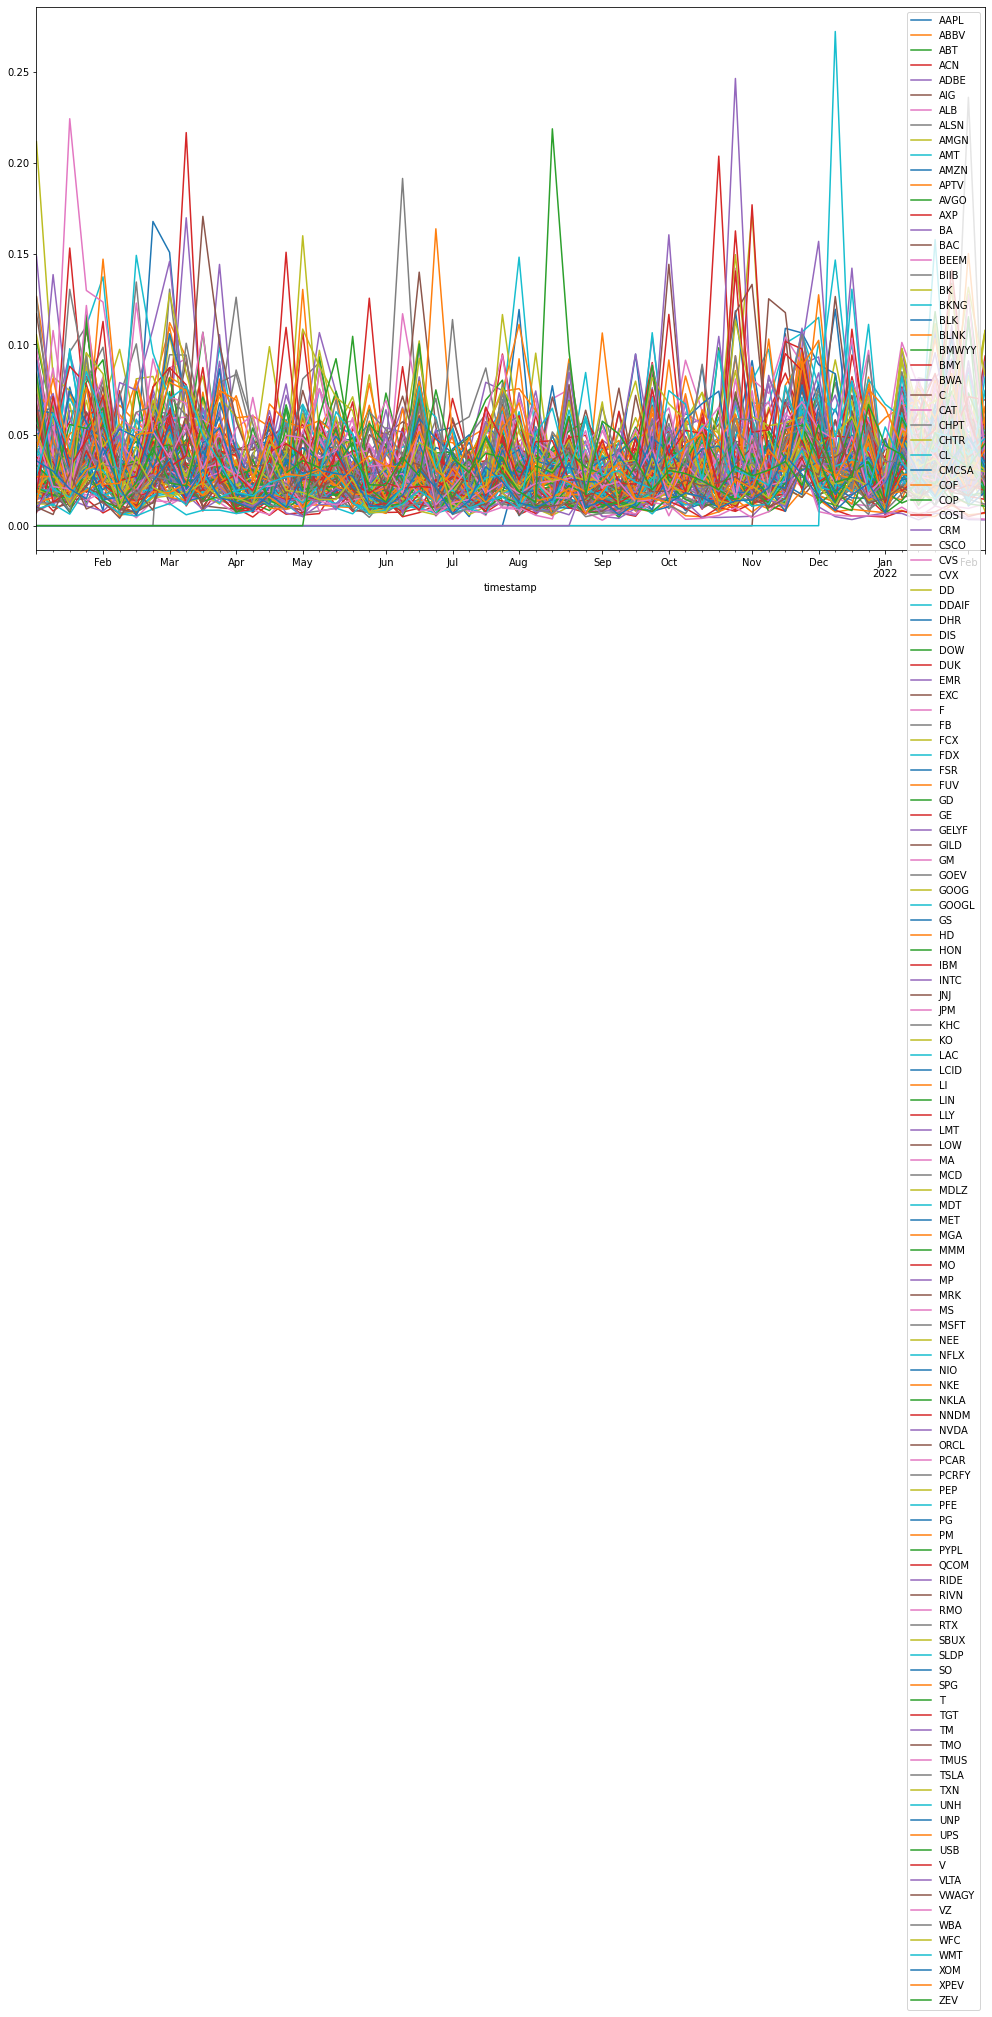

In [100]:
weekly_std.plot(figsize=(17,10))

In [101]:
df_prices.transpose()

,2021-01-04 09:30:00-05:00,2021-01-04 10:30:00-05:00,2021-01-04 11:30:00-05:00,2021-01-04 12:30:00-05:00,2021-01-04 13:30:00-05:00,2021-01-04 14:30:00-05:00,2021-01-04 15:30:00-05:00,2021-01-05 09:30:00-05:00,2021-01-05 10:30:00-05:00,2021-01-05 11:30:00-05:00,...,2022-02-10 13:30:00-05:00,2022-02-10 14:30:00-05:00,2022-02-10 15:30:00-05:00,2022-02-11 09:30:00-05:00,2022-02-11 10:30:00-05:00,2022-02-11 11:30:00-05:00,2022-02-11 12:30:00-05:00,2022-02-11 13:30:00-05:00,2022-02-11 14:30:00-05:00,2022-02-11 15:30:00-05:00
AAPL,0.22253,0.204936,0.179954,0.191948,0.190737,0.192407,0.19757,0.222506,0.212301,0.208806,...,0.860456,0.855049,0.848291,0.840091,0.845254,0.841458,0.829537,0.798481,0.79628,0.790281
ABBV,0.085523,0.073818,0.057095,0.061276,0.065456,0.075729,0.083134,0.080029,0.072145,0.082418,...,0.972766,0.967989,0.974678,0.981844,0.973901,0.966794,0.968467,0.967463,0.960822,0.957477
ABT,0.117631,0.079721,0.051289,0.063275,0.07108,0.07554,0.095052,0.092265,0.083783,0.093937,...,0.621881,0.614077,0.612683,0.610174,0.575052,0.581185,0.574774,0.551638,0.55554,0.549129
ACN,0.099937,0.087706,0.077022,0.080946,0.075504,0.075962,0.082493,0.080144,0.079342,0.08003,...,0.573614,0.574072,0.574817,0.559349,0.536377,0.532253,0.523258,0.500831,0.497565,0.499026
ADBE,0.270604,0.241924,0.216761,0.218077,0.224138,0.228359,0.231498,0.217501,0.217232,0.214362,...,0.281354,0.273093,0.268944,0.24968,0.234853,0.240913,0.228612,0.205884,0.202836,0.191057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WMT,0.762543,0.769724,0.728819,0.743492,0.740089,0.752303,0.779335,0.723268,0.71495,0.717661,...,0.359231,0.363636,0.359632,0.388466,0.356027,0.342011,0.340809,0.322587,0.333605,0.329396
XOM,0.008811,0.001677,0.000719,0.007069,0.003118,0.0,0.00623,0.038342,0.059909,0.062291,...,0.884254,0.884179,0.88665,0.905462,0.907978,0.905102,0.900549,0.914424,0.930503,0.933619
XPEV,0.660325,0.659561,0.620034,0.603805,0.587577,0.580302,0.58786,0.527991,0.543089,0.555649,...,0.447955,0.440123,0.442641,0.435059,0.41718,0.419717,0.413542,0.385003,0.392557,0.397034
ZEV,0.459517,0.459517,0.459517,0.459517,0.459517,0.459517,0.459517,0.459517,0.459517,0.459517,...,0.186175,0.180894,0.182214,0.183535,0.171651,0.170331,0.172972,0.138113,0.138641,0.139962


In [102]:
bdf = pd.merge(weekly_std.T, dfs, left_index=True, right_index=True) #[df_prices.transpose(), df], axis=1).fillna('')
#bdf = bdf.dropna()

In [128]:
bdf

,2021-01-10 00:00:00-05:00,2021-01-17 00:00:00-05:00,2021-01-24 00:00:00-05:00,2021-01-31 00:00:00-05:00,2021-02-07 00:00:00-05:00,2021-02-14 00:00:00-05:00,2021-02-21 00:00:00-05:00,2021-02-28 00:00:00-05:00,2021-03-07 00:00:00-05:00,2021-03-14 00:00:00-05:00,...,preMarketPrice,logo_url,trailingPegRatio,address2,fax,underlyingSymbol,underlyingExchangeSymbol,headSymbol,uuid,symbol
AAPL,0.019355,0.016117,0.063323,0.062282,0.016655,0.013992,0.029107,0.028053,0.042932,0.023121,...,174.00,https://logo.clearbit.com/apple.com,3.3581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABBV,0.019113,0.033924,0.013993,0.076348,0.060791,0.025880,0.018777,0.022495,0.032733,0.012077,...,143.33,https://logo.clearbit.com/abbvie.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABT,0.029415,0.029639,0.014867,0.110322,0.044314,0.037612,0.046522,0.023185,0.073893,0.028141,...,128.94,https://logo.clearbit.com/abbott.com,2.4397,Abbott Park,NaN,NaN,NaN,NaN,NaN,NaN
ACN,0.018503,0.015898,0.013210,0.020162,0.012420,0.006469,0.008288,0.015701,0.028303,0.030996,...,346.97,https://logo.clearbit.com/accenture.com,2.7366,Grand Canal Harbour,353 1 646 2020,NaN,NaN,NaN,NaN,NaN
ADBE,0.020335,0.021980,0.024463,0.022031,0.027987,0.007187,0.031380,0.020551,0.048845,0.026719,...,509.14,https://logo.clearbit.com/adobe.com,1.9890,NaN,408 537 6000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFC,0.050496,0.029011,0.011375,0.024362,0.034917,0.009715,0.037956,0.021098,0.016052,0.018403,...,59.59,https://logo.clearbit.com/wellsfargo.com,NaN,NaN,NaN,NaN,NaN,NaN,0bc07f6d-ca07-3490-b750-d6d47f2b33a9,NaN
WMT,0.027665,0.061872,0.042403,0.084928,0.058557,0.024922,0.148965,0.095112,0.069950,0.076826,...,136.50,https://logo.clearbit.com/stock.walmart.com,NaN,NaN,NaN,NaN,NaN,NaN,902d429a-38af-3903-a1d7-3374c3560928,NaN
XOM,0.035756,0.030058,0.020303,0.014852,0.042885,0.020953,0.005695,0.024452,0.036876,0.016203,...,78.73,https://logo.clearbit.com/corporate.exxonmobil...,NaN,NaN,972-940-6143,NaN,NaN,NaN,623c29c3-4307-34c2-840f-d89284dd4857,NaN
XPEV,0.041909,0.081215,0.038186,0.076135,0.022764,0.023388,0.050214,0.051423,0.079100,0.074519,...,38.70,https://logo.clearbit.com/xiaopeng.com,NaN,Changxing Street Cencun Tianhe District,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
gtypes = get_dtypes_for_dataframe(bdf, verbose=True)

[feature_utils.py:206 - get_dtypes_for_dataframe() ] bool has 2 members
[feature_utils.py:206 - get_dtypes_for_dataframe() ] int64 has 2 members
[feature_utils.py:206 - get_dtypes_for_dataframe() ] float64 has 185 members
[feature_utils.py:206 - get_dtypes_for_dataframe() ] object has 28 members


In [ ]:
df_target = (vol2/vol2.mean()).mean(axis=1)

In [ ]:
df_target.resample('W').agg(['mean', 'min', 'max', 'std', 'skew'])

In [ ]:
df_target.resample('M').agg(['mean', 'min', 'max', 'std']).T

In [ ]:
df_target.resample('M').agg(['mean', 'min', 'max', 'std']).plot()

In [ ]:
from sklearn.cross_decomposition import CCA
clf = CCA(n_components=2)
res=clf.fit_transform(df_prices, df_target)

In [ ]:
res[0].T

In [ ]:
lf = pd.DataFrame({'x':res[0].T[0], 'y':res[1].T[0]}, index=df_target.index)

In [ ]:
rr=pd.concat([(lf-lf.mean())/lf.std(), (df_target-df_target.mean())/df_target.std()], axis=1)#.plot(figsize=(15, 10))

In [ ]:
rr.resample('M').agg('mean').plot()

In [ ]:
clf.coef_

In [ ]:
plt.scatter(res[0], res[1])

In [ ]:
gtypes.keys()

In [ ]:
bdf[gtypes['float64']].describe()

In [ ]:
bdf[gtypes['object']].describe()

In [ ]:
bdf[gtypes['int64']].describe()

In [49]:
def find_list_columns(df, bad_set=['[]']):
    gtypes = get_dtypes_for_dataframe(df, verbose=True)
    bad_cols = []
    for k in gtypes.keys():
        for col in gtypes[k]:
            if col in df.columns:
                mask = df.astype(str)[col].isin(bad_set)
                if any(mask):
                    print(k, col)
                    bad_cols.append(col)
    return bad_cols

# bad_cols = find_list_columns(bdf)
# print(bad_cols)
# bdf = bdf.drop(columns=bad_cols)

# Let's featurize it

In [120]:
g2 = g.nodes(bdf, 'symbol').featurize()

[feature_utils.py:143 - remove_node_column_from_ndf_and_return_ndf_from_res() ] removing node column `symbol` so we do not featurize it
[feature_utils.py:287 - check_if_textual_column() ] 
	Column `longBusinessSummary` looks textual with mean number of words 178.20
[feature_utils.py:343 - process_textual_or_other_dataframes() ] -Calculating Embeddings for column `longBusinessSummary`
[feature_utils.py:401 - process_dirty_dataframes() ] Encoding might take a few minutes --------
[feature_utils.py:408 - process_dirty_dataframes() ] -Fitting SuperVectorizer on DATA took 0.04 minutes

[feature_utils.py:415 - process_dirty_dataframes() ] -Shape of data (133, 815)

[feature_utils.py:416 - process_dirty_dataframes() ] -Transformers: [('low_card_cat', OneHotEncoder(), ['sector', 'state', 'country', 'companyOfficers', 'recommendationKey', 'financialCurrency', 'exchange', 'exchangeTimezoneName', 'exchangeTimezoneShortName', 'quoteType', 'market', 'lastSplitFactor', 'currency', 'address2', 'fax']

In [121]:
a, b = np.where(g2.node_features == np.inf)
a, b

(array([57]), array([1138]))

In [122]:
X = g2.node_features.replace(np.inf, -1)

In [123]:
g3=g2.umap(scale=1, X=X)

[feature_utils.py:787 -                 umap() ] There are repeat entities in node table, we will not relabel nodes
[feature_utils.py:674 - _featurize_or_get_nodes_data_if_X_is_None() ] Fetching `node_target` in `res`. Target is type <class 'NoneType'>
[umap_utils.py:93 -                  fit() ] Starting UMAP-ing data of shape (133, 1199)
[umap_utils.py:106 -      _edge_influence() ] Calculating weighted adjacency (edge) DataFrame
[umap_utils.py:97 -                  fit() ] -UMAP-ing took 0.04 minutes total
[umap_utils.py:98 -                  fit() ]  - or 3550.77 rows per minute
[feature_utils.py:517 - prune_weighted_edges_df() ] Pruning weighted edge DataFrame from 2064 to 366 edges


In [127]:
g3._nodes

,2021-01-10 00:00:00-05:00,2021-01-17 00:00:00-05:00,2021-01-24 00:00:00-05:00,2021-01-31 00:00:00-05:00,2021-02-07 00:00:00-05:00,2021-02-14 00:00:00-05:00,2021-02-21 00:00:00-05:00,2021-02-28 00:00:00-05:00,2021-03-07 00:00:00-05:00,2021-03-14 00:00:00-05:00,...,trailingPegRatio,address2,fax,underlyingSymbol,underlyingExchangeSymbol,headSymbol,uuid,symbol,x,y
AAPL,0.019355,0.016117,0.063323,0.062282,0.016655,0.013992,0.029107,0.028053,0.042932,0.023121,...,3.3581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.491341,41.249981
ABBV,0.019113,0.033924,0.013993,0.076348,0.060791,0.025880,0.018777,0.022495,0.032733,0.012077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.833122,51.516556
ABT,0.029415,0.029639,0.014867,0.110322,0.044314,0.037612,0.046522,0.023185,0.073893,0.028141,...,2.4397,Abbott Park,NaN,NaN,NaN,NaN,NaN,NaN,81.432541,57.544361
ACN,0.018503,0.015898,0.013210,0.020162,0.012420,0.006469,0.008288,0.015701,0.028303,0.030996,...,2.7366,Grand Canal Harbour,353 1 646 2020,NaN,NaN,NaN,NaN,NaN,80.902397,56.852932
ADBE,0.020335,0.021980,0.024463,0.022031,0.027987,0.007187,0.031380,0.020551,0.048845,0.026719,...,1.9890,NaN,408 537 6000,NaN,NaN,NaN,NaN,NaN,82.450798,57.788063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFC,0.050496,0.029011,0.011375,0.024362,0.034917,0.009715,0.037956,0.021098,0.016052,0.018403,...,NaN,NaN,NaN,NaN,NaN,NaN,0bc07f6d-ca07-3490-b750-d6d47f2b33a9,NaN,34.841389,33.654953
WMT,0.027665,0.061872,0.042403,0.084928,0.058557,0.024922,0.148965,0.095112,0.069950,0.076826,...,NaN,NaN,NaN,NaN,NaN,NaN,902d429a-38af-3903-a1d7-3374c3560928,NaN,87.276367,45.710938
XOM,0.035756,0.030058,0.020303,0.014852,0.042885,0.020953,0.005695,0.024452,0.036876,0.016203,...,NaN,NaN,972-940-6143,NaN,NaN,NaN,623c29c3-4307-34c2-840f-d89284dd4857,NaN,86.984131,47.782219
XPEV,0.041909,0.081215,0.038186,0.076135,0.022764,0.023388,0.050214,0.051423,0.079100,0.074519,...,NaN,Changxing Street Cencun Tianhe District,NaN,NaN,NaN,NaN,NaN,NaN,30.565247,36.725117


In [124]:
g3.plot()

In [125]:
list(g3.node_encoder.get_feature_names_out())

['sector_Basic Materials',
 'sector_Communication Services',
 'sector_Consumer Cyclical',
 'sector_Consumer Defensive',
 'sector_Energy',
 'sector_Financial Services',
 'sector_Healthcare',
 'sector_Industrials',
 'sector_Real Estate',
 'sector_Technology',
 'sector_Utilities',
 'sector_nan',
 'state_AR',
 'state_AZ',
 'state_BC',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_IL',
 'state_IN',
 'state_MA',
 'state_MD',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_NC',
 'state_NE',
 'state_NJ',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_ON',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_TN',
 'state_TX',
 'state_VA',
 'state_WA',
 'state_nan',
 'country_Canada',
 'country_China',
 'country_Germany',
 'country_Hong Kong',
 'country_Ireland',
 'country_Israel',
 'country_Japan',
 'country_United Kingdom',
 'country_United States',
 'country_nan',
 'companyOfficers_[]',
 'companyOfficers_nan',
 'recommendationKey_buy',
 'recommend

In [ ]:
g3.plot()

In [ ]:
bdf = bdf.drop(columns=)

In [ ]:

g4 = g.nodes(bdf, 'symbol').featurize()